In [0]:
import pandas as pd
import numpy as np
import re
import time
import nltk
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
warnings.filterwarnings(action = 'ignore') 


**Data Load**

In [0]:
las_vegas_data= pd.read_pickle('/content/drive/My Drive/las_vegas_data_tokenized_final.pkl')
las_vegas_data.shape

**Text Vectorization**

In [0]:
start= time.time()
vector = TfidfVectorizer(tokenizer=lambda doc: doc, lowercase=False, max_features=500)
vectorizer= vector.fit_transform(las_vegas_data['imp_tags'])
print("Time to load data: {} seconds".format(time.time() - start))
# vectorizer.vocabulary_
# len(vectorizer.vocabulary_)
# vector.get_feature_names()

Time to load data: 18.525668144226074 seconds


In [0]:
vector.get_feature_names()

In [0]:
{k: v for k, v in sorted(vector.vocabulary_.items(), key=lambda item: item[1], reverse=True)}

**Linear SVM**

In [0]:

scores= pd.DataFrame()

# C=[0.001,0.01,0.1,1,10,100]
C=[1]
X=vectorizer
y=las_vegas_data['label']
dict_accuracy = {}
# dict_roc ={}

start= time.time()
for c in C:
  dict_accuracy[c] = []
  print('Started for C=',c)
  svm = LinearSVC(dual=False, max_iter=10000, C=c).fit(X, y)
  print('Finished Modeling for C=',c)
  acc_scores = cross_val_score(svm, X, y, cv=5, scoring='accuracy') 
  dict_accuracy[c].append(acc_scores)
  print('Stored c and scores for C=',c)
  print('Finished for C=', c)

print("Time to load data: {} seconds".format(time.time() - start))

Started for C= 1
Finished Modeling for C= 1
Stored c and scores for C= 1
Finished for C= 1
Time to load data: 25.071166038513184 seconds


**SVM: Weigths and tokens**

In [0]:

las_vegas_coefs= pd.DataFrame({'score': svm.coef_[0], 'words': vector.get_feature_names()})
las_vegas_coefs.set_index('words', inplace=True)
las_vegas_coefs= las_vegas_coefs.sort_values(by='score', ascending=False)
las_vegas_coefs.head(20)

**Comparing SVM Accuracy with SVD**

In [0]:
dict_accuracy_pca = {}
X=vectorizer
y=las_vegas_data['label']

svd = TruncatedSVD(n_components=5, n_iter=7, random_state=42).fit(X)

start= time.time()
for components in range(1,7):
  reducedX = svd.transform(X)
  dict_accuracy_pca[components] =[]
  svm_pca = LinearSVC(dual=False, max_iter=10000).fit(reducedX, y)
  scores_pca = cross_val_score(svm_pca, reducedX, y,cv=5, scoring='accuracy')
  dict_accuracy_pca[components].append(scores_pca)

print("Time to load data: {} seconds".format(time.time() - start))

Time to load data: 53.699111223220825 seconds


**Plot SVM vs SVM + SVD**

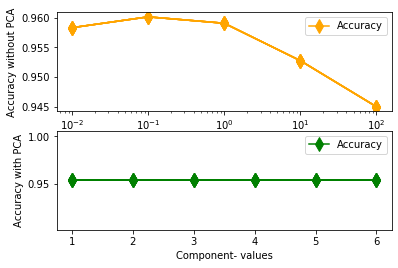

In [0]:
import matplotlib.pyplot as plt
fig, (ax1,ax2) = plt.subplots(2)
for c, x in dict_accuracy.items(): 
    non_avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy.items()}
    avg_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy_pca.items()}
    acc_list = sorted(non_avg_score.items())
    pca_list = sorted(avg_score.items())
    x_plot, y_plot = zip(*acc_list)
    x, y = zip(*pca_list)
    ax1.plot(x_plot, y_plot, color='orange',marker='d',markersize=10)
    ax2.plot(x, y, color='green',marker='d',markersize=10)

# ax1.title('Accurracy with and without PCA', fontsize=12)    
ax1.set_ylabel('Accuracy without PCA',fontsize=10)
ax1.legend(['Accuracy'],loc='upper right',fontsize=10)
ax1.set_xlabel('C- values',fontsize=10)
ax1.set_xscale('log')

ax2.set_ylabel('Accuracy with PCA',fontsize=10)
ax2.legend(['Accuracy'],loc='bottom right',fontsize=10)
ax2.set_xlabel('Component- values',fontsize=10)
# ax2.set_xscale('log')
plt.show()

**Logistic Classifier**

In [0]:
scores= pd.DataFrame()

# C=[0.001,0.01,0.1,1,10,100]
C=[1]
X=vectorizer
y=las_vegas_data['label']
dict_accuracy_log = {}

start= time.time()
for c in C:
  dict_accuracy_log[c] = []
  print('Started for C=',c)
  log = LogisticRegression(max_iter=10000, C=c).fit(X, y)
  print('Finished Modeling for C=',c)
  acc_scores_log = cross_val_score(log, X, y, cv=5, scoring='accuracy') 
  dict_accuracy_log[c].append(acc_scores_log)
  print('Stored c and scores for C=',c)
  print('Finished for C=', c)

print("Time to load data: {} seconds".format(time.time() - start))

**Plot Accuracy SVM and Logistic**

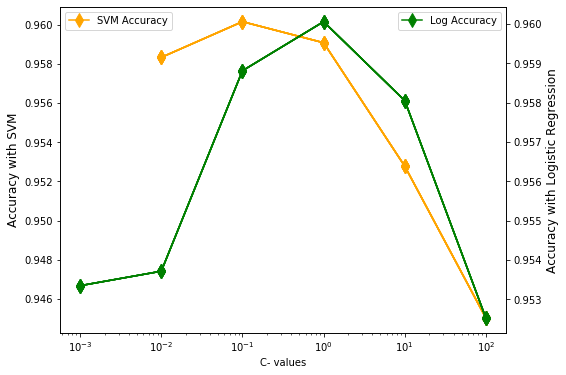

In [0]:

fig, ax1 = plt.subplots(figsize=(8,6))
ax2=ax1.twinx()
for c, x in dict_accuracy.items(): 
    svm_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy.items()}
    log_score = {k:np.mean(np.array(v)) for k,v in dict_accuracy_log.items()}
    acc_list = sorted(svm_score.items())
    log_list = sorted(log_score.items())
    x_plot, y_plot = zip(*acc_list)
    x, y = zip(*log_list)
    ax1.plot(x_plot, y_plot, color='orange',marker='d',markersize=10)
    ax2.plot(x, y, color='green',marker='d',markersize=10)

ax1.set_ylabel('Accuracy with SVM',fontsize=12)
ax1.legend(['SVM Accuracy'],loc=2,fontsize=10)
ax1.set_xlabel('C- values',fontsize=10)
ax1.set_xscale('log')

ax2.set_ylabel('Accuracy with Logistic Regression',fontsize=12)
ax2.legend(['Log Accuracy'],loc=1,fontsize=10)
# ax2.set_xscale('log')
plt.show()

24.034786462783813


**Positive vs Negative words analysis**

In [0]:
def plot_coefficients(classifier, feature_names, top_features=20):
 coef = classifier.coef_.ravel()
 top_positive_coefficients = np.argsort(coef)[-top_features:]
 top_negative_coefficients = np.argsort(coef)[:top_features]
 top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])
 plt.figure(figsize=(13, 5))
 colors = ['orange' if c < 0 else 'green' for c in coef[top_coefficients]]
 plt.bar(np.arange(2 * top_features), coef[top_coefficients], color=colors)
 feature_names = np.array(feature_names)
 plt.xticks(np.arange(0, 1 + 2 * top_features), feature_names[top_coefficients], rotation=60, ha='right')
 plt.ylabel('weights of words')
 plt.title('Top 20 positive and negative words\n')
 plt.show()

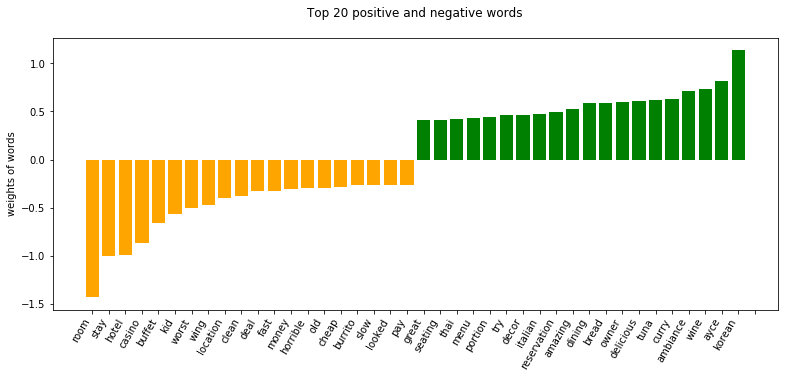

In [0]:
plot_coefficients(svm, vector.get_feature_names())